In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/PyTorch Notebooks/LeNet')
!pwd
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/content/drive/MyDrive/Colab Notebooks/PyTorch Notebooks/LeNet


In [3]:
batch_size = 32
train_dataset = datasets.MNIST('/dataset',train=True,transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = datasets.MNIST('/dataset',train=False,transform=transforms.ToTensor(), download=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
classes = train_dataset.classes

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /dataset/MNIST/raw/train-images-idx3-ubyte.gz to /dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /dataset/MNIST/raw/train-labels-idx1-ubyte.gz to /dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to /dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to /dataset/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
print(train_loader.dataset.data.shape)
print(test_loader.dataset.data.shape)
print(classes)

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])
['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


In [5]:
train_data_iter = iter(train_loader)
images, labels = train_data_iter.next()
print(images.shape)
print(labels.shape)

torch.Size([32, 1, 28, 28])
torch.Size([32])


In [6]:
def train_image_show(images, labels):
  num_images = images.shape[0]
  fig, ax = plt.subplots(nrows= 1 if num_images<5 else int(np.ceil(num_images/4)), ncols = num_images if num_images<5 else 4, figsize=(10,10))
  if num_images<5:
    for i in range(num_images):
      ax[i].imshow(images[i].reshape(28,28),cmap='gray',interpolation='none')
      ax[i].axis('off')
      ax[i].set_title(classes[int(labels[i])])
  else:
    n = 0
    for i in range(int(np.ceil(num_images/4))):
      for j in range(4):
        if n<num_images:
          ax[i,j].imshow(images[n].reshape(28,28),cmap='gray',interpolation='none')
          ax[i,j].axis('off')
          ax[i,j].set_title(classes[int(labels[n])])
        else:
          fig.delaxes(ax[i,j])
        n=n+1
  plt.tight_layout(pad=1, h_pad=1, w_pad=1)
  plt.show()        

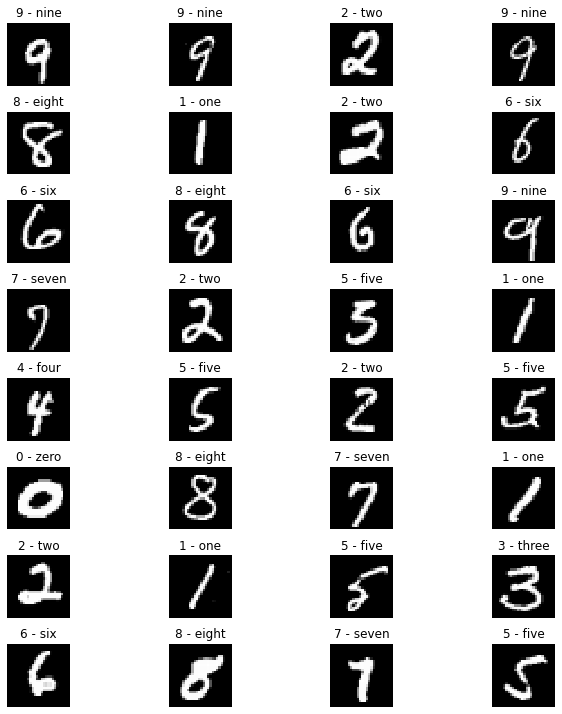

In [7]:
train_image_show(images, labels)

(array([5923., 6742., 5958., 6131., 5842., 5421., 5918., 6265., 5851.,
        5949.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

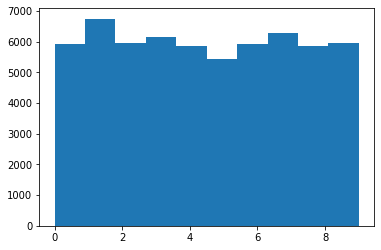

In [8]:
plt.hist(train_loader.dataset.targets)

(array([ 980., 1135., 1032., 1010.,  982.,  892.,  958., 1028.,  974.,
        1009.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

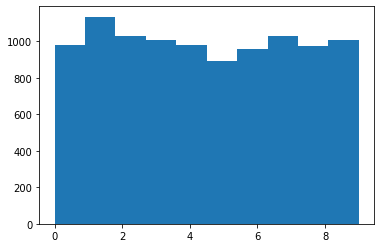

In [9]:
plt.hist(test_loader.dataset.targets)

In [10]:
class LeNet(nn.Module):
  def __init__(self, input_channel, num_classes):
    super(LeNet, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=input_channel, out_channels=6, kernel_size=(5,5), stride=(1,1), padding=(2,2))#((28+2*2-5)/1)+1=28
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=(5,5), stride=(1,1), padding=(0,0))
    self.pool = nn.AvgPool2d(kernel_size=(2,2), stride=(2,2), padding=(0,0))
    self.dense1 = nn.Linear(in_features=5*5*16, out_features=120)
    self.dense2 = nn.Linear(in_features=120, out_features=84)
    self.dense3 = nn.Linear(in_features=84, out_features=10)

  def forward(self, X):
    # print(X.shape)
    X = self.pool(torch.sigmoid(self.conv1(X)))#width and height = 28 => ((28+2*2-5)/1)+1=28 => ((28+2*2-5)/2)+1=14.5=14, channel = 1 => 6 => 6
    # print(X.shape)
    X = self.pool(torch.sigmoid(self.conv2(X)))#width and height = 14 => ((14+0*0-5)/1)+1=10 => ((10+2*2-5)/2)+1=5.5=5, channel = 6 => 16 => 16
    # print(X.shape)
    X = X.reshape(X.shape[0], -1)# in=5*5*16=400 out=120
    # print(X.shape)
    X = torch.sigmoid(self.dense1(X))# in=400 out=120
    # print(X.shape)
    X = torch.sigmoid(self.dense2(X))# in=120 out=84
    # print(X.shape)
    X = self.dense3(X)# in=84 out=10
    # print(X.shape)
    return X

In [11]:
model = LeNet(1,10).to(device)
_, preds = torch.max(model(torch.rand((32,1,28,28)).to(device)),1)
preds

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')

In [12]:
learning_rate = .001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), learning_rate)

In [13]:
def train_model(model, criterion, optimizer, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [14]:
dataloaders = {
    'train':train_loader,
    'val':test_loader
}
dataset_sizes = {
    'train':train_loader.dataset.data.shape[0],
    'val':test_loader.dataset.data.shape[0]
}
best_model_wts = train_model(model, criterion, optimizer, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7973 Acc: 0.7413
val Loss: 0.2488 Acc: 0.9227

Epoch 1/24
----------
train Loss: 0.1845 Acc: 0.9437
val Loss: 0.1408 Acc: 0.9561

Epoch 2/24
----------
train Loss: 0.1207 Acc: 0.9630
val Loss: 0.0975 Acc: 0.9687

Epoch 3/24
----------
train Loss: 0.0922 Acc: 0.9713
val Loss: 0.0760 Acc: 0.9760

Epoch 4/24
----------
train Loss: 0.0745 Acc: 0.9770
val Loss: 0.0687 Acc: 0.9791

Epoch 5/24
----------
train Loss: 0.0635 Acc: 0.9803
val Loss: 0.0561 Acc: 0.9819

Epoch 6/24
----------
train Loss: 0.0551 Acc: 0.9829
val Loss: 0.0594 Acc: 0.9811

Epoch 7/24
----------
train Loss: 0.0488 Acc: 0.9845
val Loss: 0.0554 Acc: 0.9815

Epoch 8/24
----------
train Loss: 0.0443 Acc: 0.9864
val Loss: 0.0466 Acc: 0.9841

Epoch 9/24
----------
train Loss: 0.0390 Acc: 0.9877
val Loss: 0.0502 Acc: 0.9838

Epoch 10/24
----------
train Loss: 0.0370 Acc: 0.9883
val Loss: 0.0401 Acc: 0.9876

Epoch 11/24
----------
train Loss: 0.0324 Acc: 0.9892
val Loss: 0.0531 Acc: 0.9820

Ep

In [15]:
def test_image_show(images, labels, preds):
  num_images = images.shape[0]
  fig, ax = plt.subplots(nrows= 1 if num_images<5 else int(np.ceil(num_images/4)), ncols = num_images if num_images<5 else 4, figsize=(10,10))
  if num_images<5:
    for i in range(num_images):
      ax[i].imshow(images[i].reshape(28,28),cmap='gray',interpolation='none')
      ax[i].axis('off')
      ax[i].set_title(classes[int(labels[i])]+"->"+classes[int(preds[i])])
  else:
    n = 0
    for i in range(int(np.ceil(num_images/4))):
      for j in range(4):
        if n<num_images:
          ax[i,j].imshow(images[n].reshape(28,28),cmap='gray',interpolation='none')
          ax[i,j].axis('off')
          ax[i,j].set_title(classes[int(labels[n])]+"->"+classes[int(preds[n])])
        else:
          fig.delaxes(ax[i,j])
        n=n+1
  plt.tight_layout(pad=1, h_pad=1, w_pad=1)
  plt.show() 

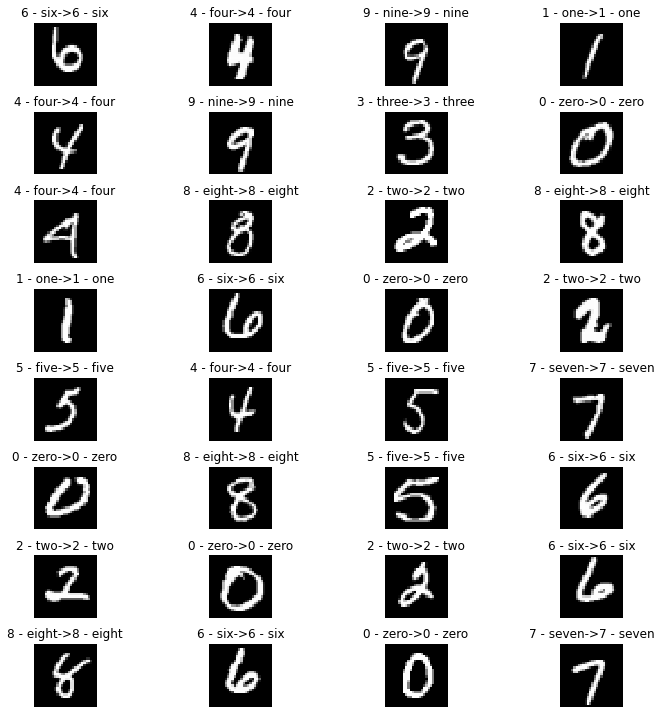

In [16]:
test_data_iter = iter(test_loader)
test_images, test_labels = test_data_iter.next()
model = best_model_wts
outputs = model(test_images.to(device))
_, preds = torch.max(outputs, 1)
# print(preds)
test_image_show(test_images,test_labels, preds)

In [18]:
torch.save(model.state_dict(), 'model_weights.pth')

Test on https://www.kaggle.com/c/digit-recognizer/overview dataset and upload the result to the competetion.

In [19]:
import pandas as pd
df = pd.read_csv('test.csv')# csv dataset from https://www.kaggle.com/c/digit-recognizer/overview
print(df)

       pixel0  pixel1  pixel2  pixel3  ...  pixel780  pixel781  pixel782  pixel783
0           0       0       0       0  ...         0         0         0         0
1           0       0       0       0  ...         0         0         0         0
2           0       0       0       0  ...         0         0         0         0
3           0       0       0       0  ...         0         0         0         0
4           0       0       0       0  ...         0         0         0         0
...       ...     ...     ...     ...  ...       ...       ...       ...       ...
27995       0       0       0       0  ...         0         0         0         0
27996       0       0       0       0  ...         0         0         0         0
27997       0       0       0       0  ...         0         0         0         0
27998       0       0       0       0  ...         0         0         0         0
27999       0       0       0       0  ...         0         0         0         0

[28

In [24]:
test_dataset = df.to_numpy()
test_dataset_image = test_dataset.reshape(test_dataset.shape[0],1,28,28)
test_dataset_image.shape

(28000, 1, 28, 28)

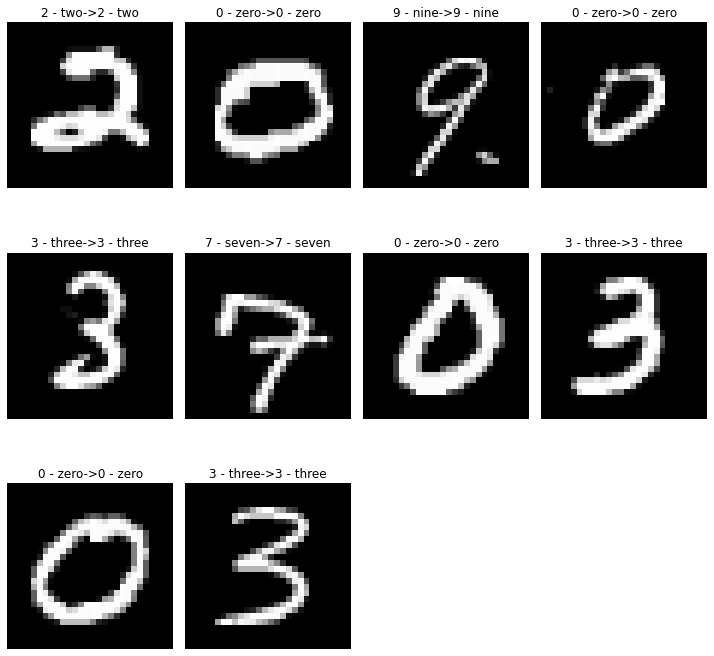

In [36]:
outputs = model(torch.from_numpy(test_dataset_image).float().to(device))
_, preds = torch.max(outputs, 1)
# print(preds)
test_image_show(test_dataset_image[:10],preds[:10], preds[:10])

In [65]:
index = np.arange(start=1, stop=preds.shape[0]+1, step=1)
size = index.shape[0]
out = np.concatenate([index.reshape(1,size),preds.cpu().detach().numpy().reshape(1,size)], axis=0)
submission = pd.DataFrame(np.transpose(out), columns = ['ImageId','Label'])
submission.to_csv('submission.csv', index=False)

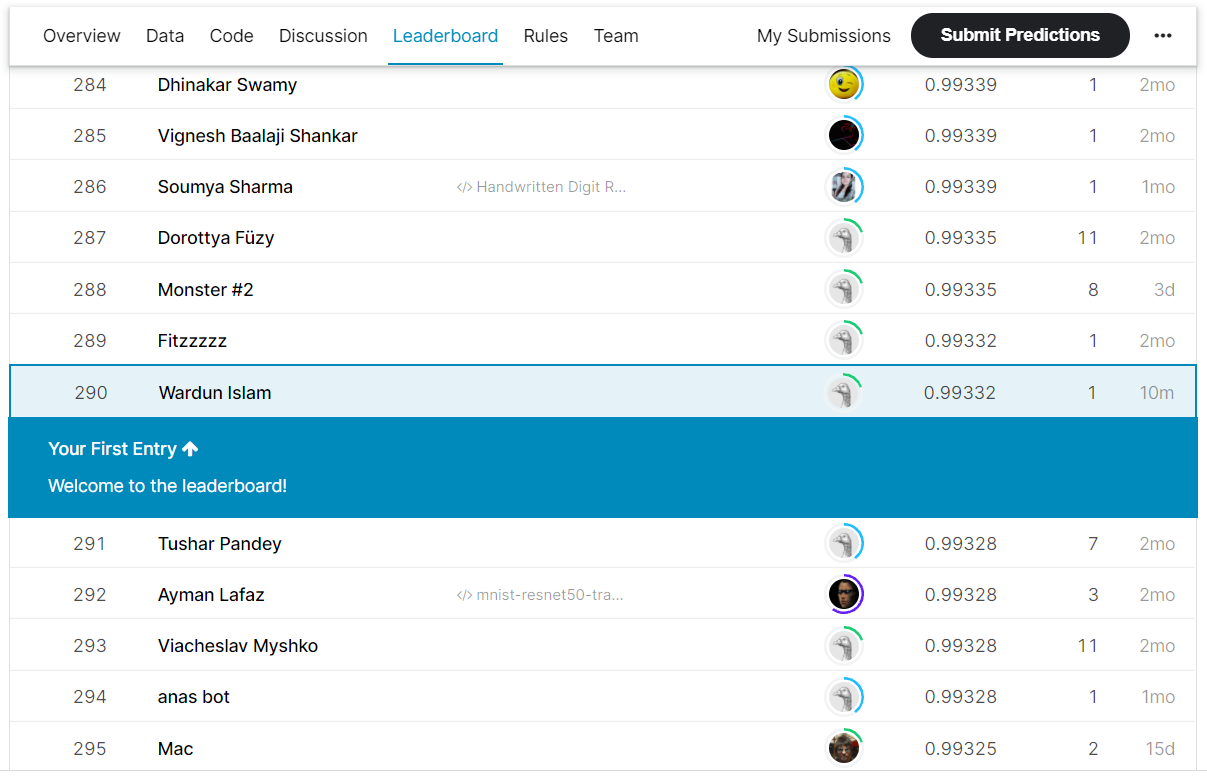